# Assignment #2: Los et al. model
Sara Iglesias Suárez-Noguerol


The second cell plots the data from the original experiment:
- Participants performed ±896 trials of the following task: after a warning stimulus, there was a foreperiod, after which participants had to generate a response to a target on the left or on the right. The foreperiod was equally likely to be either 400ms, 800ms, 1200ms or 1600ms. 

In the simulated experiment (experiment_model function), ACT-R's declarative memory is used to store the percieved time interval of each foreperiod, which will be retrieved in the next trial and used to calculated the time at which the next target is expected to appear (exp_time). 
Using the forperiod and the exp_time, the response time is calculated like in the previous assignment (response_time function).

- The maximum and minimum response times have been modified from the previous assignment, since in the experiment data the RT ranges approximately from 340 ms to 400ms (considerind upper and lower values).
- Regular retrieval has been used.
- The model's noise is set to 0.3 for a better fit.
- 15 participants are simulated, and each of them performs 900 trials.

In [4]:
from model import Model
from dmchunk import Chunk
from time_funcs import time_to_pulses, pulses_to_time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Data from the original experiment

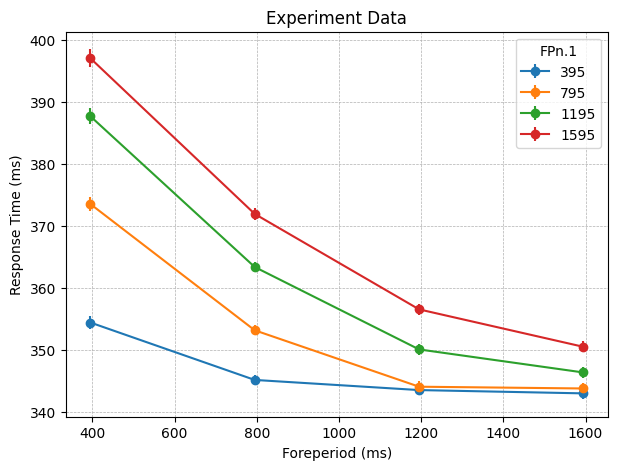

In [5]:
## Plotting the data

data = pd.read_csv('nmin1data.csv')
data = data.iloc[:, 1:]
FP = [395, 795, 1195 , 1595]

plt.figure(figsize=(7,5)) 
for FPn1 in FP:
    df = data[data["FPn.1"] == FPn1]
    plt.errorbar(df["FP"], df["RT"], yerr = [df['upper']-df["RT"], df["RT"]-df['lower']], marker = 'o' ,label = str(FPn1))
plt.legend(title = 'FPn.1')
plt.xlabel('Foreperiod (ms)')
plt.ylabel('Response Time (ms)')
plt.title('Experiment Data')
plt.grid(linestyle='--', linewidth=.5)
plt.show()


## Simulated experiment

In [6]:
## The collected memory about previous trial is used to model the RT
# RT ranges from 340ms to 400ms, as in the experimental data
def response_time(FP, pulses_av):
    exp_time = pulses_to_time(pulses_av)
    max_RT = 0.4
    diff = (FP - exp_time)
    ## The response time is calculated
    if diff < 0: 
            res_time = max_RT    
    elif diff > 0.06: 
            res_time = max_RT -  0.06
    else:
            res_time = max_RT - diff

    return res_time

In [7]:
def experiment_model(m, FP, trial): 

        #intro , go from generic explanation why the problem/research is relevant in RL, and finidsh with supported reseach questions
        """errors can trigger happines¿?"""

        #PRODUCTION TO MODEL accuracy. Ptoduction to push a button, if ot's retrieved too early, then you might pushed the wrong one
        #also maybe reaction time affects the accuracy.
        # the visual could be a constant, but it wouldn't affect the accuracy.
        
        max_RT = 0.4    # maximum response time

        # The stimulus is 50ms
        m.time += 0.05 
        query = Chunk(name = "query", slots = {"isa": 'fp'})
        chunk, latency = m.retrieve(query)      # retrieve the chunck with highest activation
        m.time += latency
        
        #Latency and the retrival 0.05 should overlap the foreperiod!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        m.time += FP -0.05 -latency   # adding the foreperiod to the model time

        
        
        if chunk == None:
                # in the first trial (or if no chunk is retreived) the response time is the maximum
                res_time = max_RT
        else:
                pulses = chunk.slots["pulses"]
                #m.add_encounter(chunk)           # Act R is very flawed so jsut dont add this chunk
                res_time = response_time(FP, pulses)
                
        
        m.time += res_time # adding the response time to the model time

        # there is a randomly jittered inter-trial interval of 1.0 - 1.5s between the response and the S1 (the warning stimulus)
        m.time += np.random.uniform(1.0, 1.5)

        pulses = time_to_pulses(FP)     # Because it will be FPN1 in the next trial
        new_chunk = Chunk(name = "trial" + str(trial), slots = {"isa": 'fp',  "pulses": pulses}) # the percived time for the fp is stored in the DM
        m.add_encounter(new_chunk)
        

        return res_time 

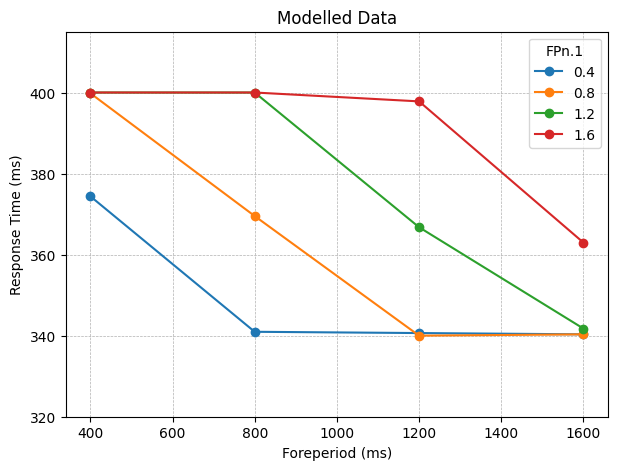

In [8]:
## Parameters of the experiment
num_subjects = 15
num_trial = 200
results = pd.DataFrame(columns = ["FP","FPn.1","RT"])

# FP foreperiod after which the user responds
# FPn1 trainig foreperiod previous to FP

forperiods = [ 0.4, 0.8, 1.2, 1.6]
FPN1 = random.choice(forperiods)

## Collecting the modelled data
for subjects in range(num_subjects):
    m = Model()
    m.s = 0.3   # model's noise
    for trial in range(num_trial):
        FP = random.choice(forperiods)
        RT = experiment_model(m, FP, trial)
        results.loc[len(results)] = [FP, FPN1, RT]
        FPN1 = FP

## Processing the modelled data        
data_avg = pd.DataFrame(columns=["FP","FPn.1","RT_avg"]) 
for fpn1 in forperiods:
    data_fp1 = results[results['FPn.1'] == fpn1]
    for fp in forperiods:
        data_fp1_fp = data_fp1[data_fp1['FP'] == fp] 
        rt_avg = np.mean(data_fp1_fp['RT'])
        data_avg.loc[len(data_avg)] = [fp, fpn1, rt_avg]

## Plotting the data
plt.figure(figsize=(7,5)) 
for fpn1 in forperiods:
    df = data_avg[data_avg["FPn.1"] == fpn1]
    plt.plot(df["FP"]* 1000, df["RT_avg"]* 1000, marker = 'o' ,label = str(fpn1))

plt.legend(title = 'FPn.1')
plt.xlabel('Foreperiod (ms)')
plt.ylabel('Response Time (ms)')
plt.title('Modelled Data')
plt.ylim([320, 415])
plt.grid(linestyle='--', linewidth=.5)
plt.show()

